# Quasi-Newton Methods

Quasi-Newton methods are designed to incrementally approximate the Hessian matrix by adding information to an approximate Hessian at each iteration. Some methods keep track of the Hessian, while other techniques are designed to approximate the inverse of the Hessian matrix.

Quasi-Newton methods enforce a secant condition that the Hessian approximation, $B_{k+1} \approx H(x)$, at the $k+1$ iteration must satisfy

\begin{equation*}
    B_{k+1} s_{k} = y_{k},
\end{equation*}

where $s_{k} = x_{k+1} - x_{k}$ and $y_{k} = \nabla f_{k+1} - \nabla f_{k}$ are the differences in the design vector and gradient vector between two iterations. It can also be useful to approximate the inverse of the Hessian, since we will generally utilize the inverse Hessian to compute the update. The secant condition for the inverse Hessian approximation can be written as

\begin{equation*}
    D_{k+1} y_{k} = s_{k},
\end{equation*}

where $D_{k+1} \approx H(x)^{-1}$.

In the following, the subscripts on the vectors $s_{k}$ and $y_{k}$ are omitted.

## BFGS

The BFGS update formula relies on the curvature criteria $y^{T} s > 0$. This ensures that the Hessian approximation remains positive definite.

The BFGS update formula for the Hessian approximation is given by:

\begin{equation*}
    B_{k+1} = B_{k} - \frac{B_{k} s\, s^{T} B_{k}}{s^{T} B_{k} s} + \rho y y^{T},
\end{equation*}

where $\rho = (y^{T} s)^{-1}$. Here the subscripts on the $y$ and $s$ vectors have been removed.

The inverse Hessian update formula is given by 

\begin{equation*}
    D_{k+1} = (I - \rho s y^{T}) D_{k} (I - \rho y s^{T}) + \rho s s^{T}.
\end{equation*}

In this example, we explore the performance of the methods on the quadratic function

\begin{equation*}
    f(x) = \frac{1}{2}x^{T} A x + b^{T}x
\end{equation*}

where $A$ is symmetric positive definite. In practice, we will also utilize an inexact line search method, but in this instance, we can use exact line searches since we have the quadratic form of the function.

While there are several families of rank-2 update formula for quasi-Newton methods that can be applied (the Broyden class for instance), BFGS is the most common. This is due to the mathematical properties of the BFGS method that enable it to recover from a poor initial guess. These properties have been verified based on extensive analysis and numerical testing.

In this notebook, we look at the error in the eigenvalues of the Hessian matrix $B \approx A$ and the inverse matrix $D \approx A^{-1}$. Note that we construct the matrix $A$ with a known eigenspectra while the matrix $A^{-1}$ should have eigenvalues $1/\lambda(A)$. 

## SR1 (Symmetric rank-1 update)

In this section, we explore the performance of the symmetric rank-1 update. This update can be found as follows

\begin{equation*}
    B_{k+1} = B_{k} + \frac{(y - B_{k} s)(y - B_{k} s)^{T}}{(y - B_{k} s)^T s}
\end{equation*}

The update to the inverse of the Hessian can be written as

\begin{equation*}
    D_{k+1} = D_{k} + \frac{(s - D_{k} y)(s - D_{k}y)^{T}}{(s - D_{k}y)^{T}y}
\end{equation*}

Note that the update for the inverse Hessian can be obtained from the update for the Hessian by swapping $B_{k}$ with $D_{k}$, and switching $y$ for $s$ and $s$ for $y$.


Condition number:              10.0
Final eigenvalues for B:       [ 1. 10.]
Final eigenvalues for inv(D):  [ 1. 10.]


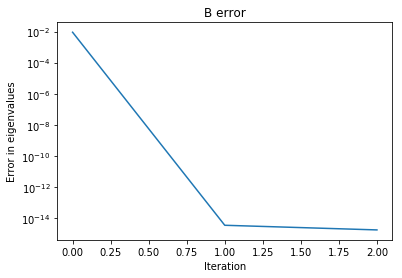

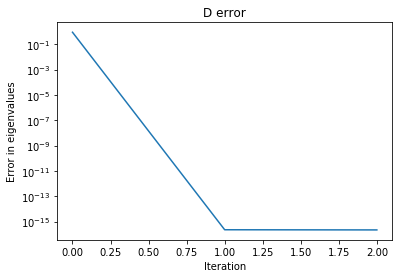

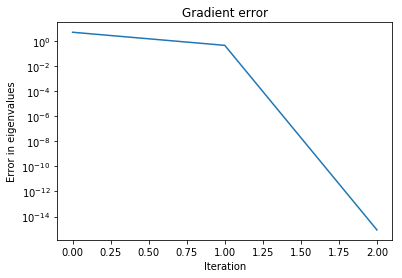

Condition number:              10.0
Final eigenvalues for B:       [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Final eigenvalues for inv(D):  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


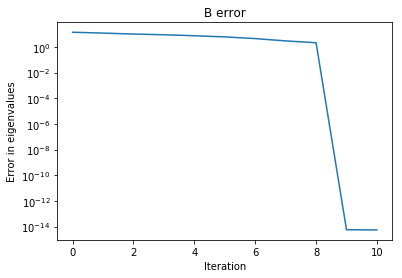

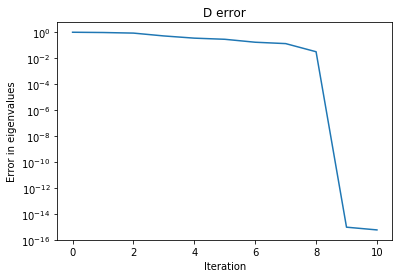

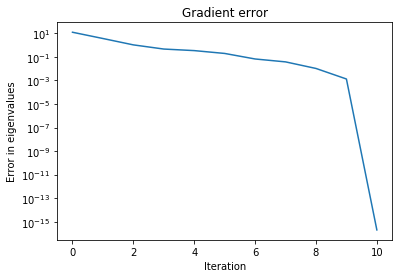

Condition number:              999999.9999999998
Final eigenvalues for B:       [1.00000000e-03 2.75547773e-02 1.28086282e-01 3.52078947e-01
 7.49017204e-01 1.36838549e+00 2.25966822e+00 3.47234985e+00
 5.05591481e+00 7.05984751e+00 9.53363241e+00 1.25267539e+01
 1.60886965e+01 2.02689445e+01 2.51169825e+01 3.06822948e+01
 3.70143659e+01 4.41626802e+01 5.21767222e+01 6.11059763e+01
 7.09999268e+01 8.19080583e+01 9.38798552e+01 1.06964802e+02
 1.21212383e+02 1.36672082e+02 1.53393385e+02 1.71425775e+02
 1.90818738e+02 2.11621756e+02 2.33884316e+02 2.57655900e+02
 2.82985995e+02 3.09924083e+02 3.38519651e+02 3.68822181e+02
 4.00881158e+02 4.34746068e+02 4.70466394e+02 5.08091620e+02
 5.47671232e+02 5.89254713e+02 6.32891548e+02 6.78631222e+02
 7.26523218e+02 7.76617022e+02 8.28962118e+02 8.83607990e+02
 9.40604122e+02 1.00000000e+03]
Final eigenvalues for inv(D):  [1.00000000e-03 2.75547773e-02 1.28086282e-01 3.52078947e-01
 7.49017204e-01 1.36838549e+00 2.25966822e+00 3.47234985e+00
 5.

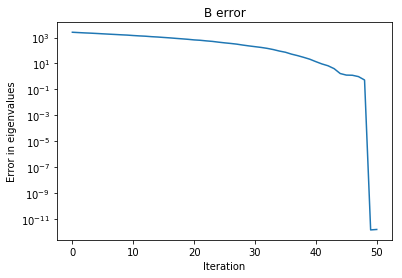

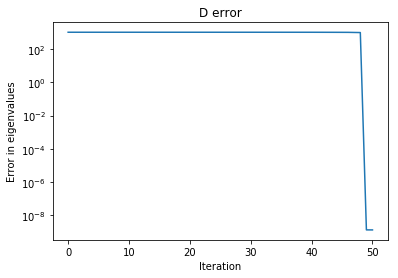

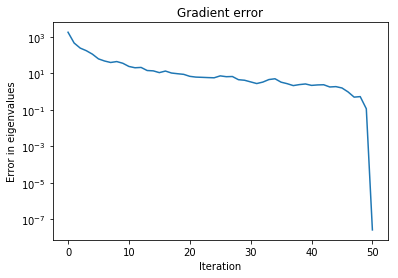

In [14]:
import numpy as np
import matplotlib.pylab as plt

def create_matrix_from_eigs(lam):
    '''Generate a random matrix with the specified updates'''
    n = len(lam)
    lam = np.array(lam)
    
    B = -1.0 + 2.0*np.random.uniform(size=(n, n))
    Q, r = np.linalg.qr(B, mode='complete')
    A = np.dot(Q, np.dot(np.diag(lam), Q.T))
    
    return A

class BFGS:
    def __init__(self, n):
        self.n = n        
        self.D = None
        self.B = None
        return
    
    def update(self, s, y):
        '''Perform the update'''
        
        # Check the curvature condition
        if np.dot(y, s) >= 0.0:
            # Compute the value of rho
            rho = 1.0/np.dot(y, s)

            # If we're on the initial iteration, reset the new values
            if self.D is None:
                scale = np.dot(y, s)/np.dot(y, y)
                self.D = scale*np.eye(self.n)

            # Compute the BFGS update
            W = np.eye(self.n) - rho*np.outer(y, s)
            self.D = np.dot(W.T, np.dot(self.D, W))
            self.D += rho*np.outer(s, s)
            
            if self.B is None:
                scale = np.dot(y, y)/np.dot(y, s)
                self.B = np.eye(self.n)
            
            r = np.dot(self.B, s)
            beta = 1.0/np.dot(s, r)
            self.B = self.B - beta*np.outer(r, r) + rho*np.outer(y, y)
            
        return
    
class SR1:
    def __init__(self, n, tol=1e-12):
        self.n = n        
        self.D = np.eye(self.n)
        self.B = np.eye(self.n)
        self.tol = tol
        return
    
    def update(self, s, y):
        '''Perform the update'''
        
        # Update the Hessian approximation
        r = y - np.dot(self.B, s)
        beta = np.dot(r, s)
        if np.fabs(beta)/np.dot(s, s) > self.tol:
            self.B += np.outer(r, r)/beta
        
        # Update the approximate inverse Hessian
        r = s - np.dot(self.D, y)
        beta = np.dot(r, y)
        if np.fabs(beta)/np.dot(s, s) > self.tol:
            self.D += np.outer(r, r)/beta
            
        return

def test_quasi_newton(lam, qn_type='bfgs', max_iters=-1):
    '''
    Test the quasi-Newton method using a quadratic 
    with exact line searches
    '''
    # Set the max number of iterations (unless it is set externally)
    if max_iters < 0:
        max_iters = len(lam)+1

    # Sort the eigenvalues and convert them to a numpy array
    lam = np.array(sorted(lam))
        
    # Quit if this is not a positive definite case
    if lam[0] <= 0.0:
        print('Only works for positive definte cases')
        return
    
    # Create the matrix from the eigenvalues
    n = len(lam)
    A = create_matrix_from_eigs(lam)
    
    # Create the quadratic right-hand-side
    b = np.random.uniform(size=n)
    
    # Create the BFGS object
    qn = None
    if qn_type == 'bfgs':
        qn = BFGS(n)
    else:
        qn = SR1(n)
    
    # Set the starting point
    x = np.random.uniform(size=n)
    
    error_gradient = np.zeros(max_iters)
    error_B = np.zeros(max_iters)
    error_D = np.zeros(max_iters)
    for i in range(max_iters):
        # Compute the function gradient
        g = np.dot(A, x) + b
        
        # Compute the l2 norm of the gradient
        error_gradient[i] = np.sqrt(np.dot(g, g))
        
        # Find the search direction
        if i == 0:
            p = -g
        else:
            p = -np.linalg.solve(qn.B, g)
    
        # Compute the exact line search step length
        alpha = -np.dot(p, g)/np.dot(p, np.dot(A, p))

        # Compute the step and the difference in the gradients
        s = alpha*p
        y = np.dot(A, s)
        
        # Update the value of x
        x += s
        
        # Update the quasi-Newton formula
        qn.update(s, y)
        
        # Compute the eigenvalues of the Hessian approximation
        eigs, v = np.linalg.eigh(qn.B)
                
        # Compute the error
        error_B[i] = np.sqrt(np.dot(eigs - lam, eigs - lam))

        # Compute the eigenvalues of the Hessian approximation
        eigs, v = np.linalg.eigh(qn.D)
        
        # Compute the error
        error_D[i] = np.sqrt(np.dot(eigs[::-1] - 1.0/lam,
                                    eigs[::-1] - 1.0/lam))
    
    print('Condition number:             ', lam[-1]/lam[0])
    
    eigs, v = np.linalg.eigh(qn.B)
    print('Final eigenvalues for B:      ', eigs)

    eigs, v = np.linalg.eigh(qn.D)
    print('Final eigenvalues for inv(D): ', 1.0/eigs[::-1])

    plt.figure()
    plt.semilogy(np.arange(max_iters), error_B)
    plt.title('B error')
    plt.xlabel('Iteration')
    plt.ylabel('Error in eigenvalues')

    plt.figure()
    plt.semilogy(np.arange(max_iters), error_D)
    plt.title('D error')
    plt.xlabel('Iteration')
    plt.ylabel('Error in eigenvalues')

    plt.figure()
    plt.semilogy(np.arange(max_iters), error_gradient)
    plt.title('Gradient error')
    plt.xlabel('Iteration')
    plt.ylabel('Error in eigenvalues')

    return

test_quasi_newton([1, 10])
plt.show()

test_quasi_newton([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.show()

test_quasi_newton(np.linspace(0.1, 10)**3)
plt.show()

Condition number:              10.0
Final eigenvalues for B:       [ 1. 10.]
Final eigenvalues for inv(D):  [ 1. 10.]


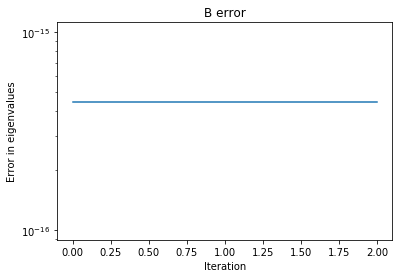

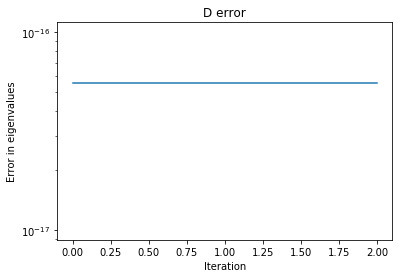

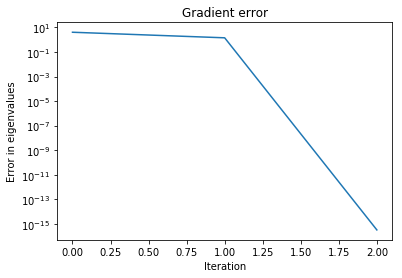

Condition number:              10.0
Final eigenvalues for B:       [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Final eigenvalues for inv(D):  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


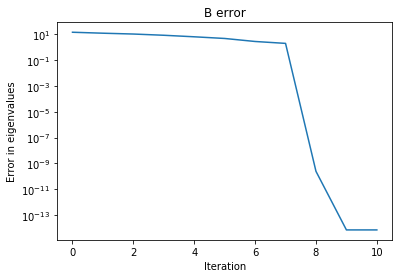

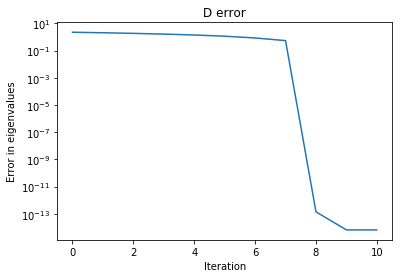

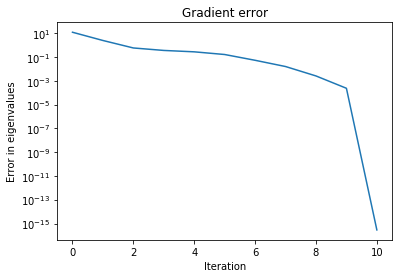

Condition number:              999999.9999999998
Final eigenvalues for B:       [1.00000000e-03 2.75547773e-02 1.28086282e-01 3.52078947e-01
 7.49017204e-01 1.36838549e+00 2.25966822e+00 3.47234985e+00
 5.05591481e+00 7.05984751e+00 9.53363241e+00 1.25267539e+01
 1.60886965e+01 2.02689445e+01 2.51169825e+01 3.06822948e+01
 3.70143659e+01 4.41626802e+01 5.21767222e+01 6.11059763e+01
 7.09999268e+01 8.19080583e+01 9.38798552e+01 1.06964802e+02
 1.21212383e+02 1.36672082e+02 1.53393385e+02 1.71425775e+02
 1.90818738e+02 2.11621756e+02 2.33884316e+02 2.57655900e+02
 2.82985995e+02 3.09924083e+02 3.38519651e+02 3.68822181e+02
 4.00881158e+02 4.34746068e+02 4.70466394e+02 5.08091620e+02
 5.47671232e+02 5.89254713e+02 6.32891548e+02 6.78631222e+02
 7.26523218e+02 7.76617022e+02 8.28962118e+02 8.83607990e+02
 9.40604122e+02 1.00000000e+03]
Final eigenvalues for inv(D):  [1.00000000e-03 2.75547773e-02 1.28086282e-01 3.52078947e-01
 7.49017204e-01 1.36838549e+00 2.25966822e+00 3.47234985e+00
 5.

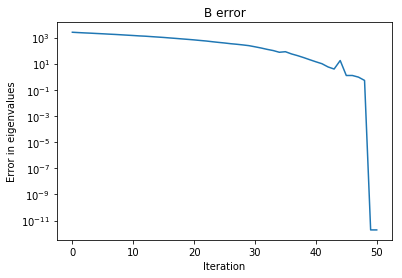

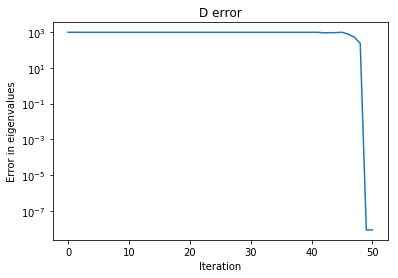

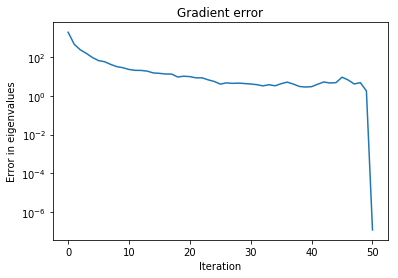

In [13]:
test_quasi_newton([1, 10], qn_type='sr1')
plt.show()

test_quasi_newton([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], qn_type='sr1')
plt.show()

test_quasi_newton(np.linspace(0.1, 10)**3, qn_type='sr1')
plt.show()